## Exploration of the SDG tweet counts
In 2015 the UN general assembly set the 2030 Sustainable Development Goals. Using the tweet counts tool from the twitter API is possible to extract the use of the #SDG hashtag from 2015 to date.

In [ ]:
# imports
import tweepy
import os
import requests
import csv
import dateutil.parser
import datetime
import time
import pickle
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [ ]:
# set bearer token as an enviroment variable
os.environ['TOKEN_ACADEMIC'] = 'INSERT YOUR ACADEMIC TOKEN'

In [ ]:
def auth():
    return os.getenv('TOKEN_ACADEMIC')

#### Build the request for the tweet counts:
The tweepy community-built python library will be used to simplify the request programming process

In [ ]:
# Authorization
bearer_token = auth()
client = tweepy.Client(bearer_token)

Query operators can be used to filter the tweets that should be included in your count or tweet collection.
The considered query operators are the following:
* keyword : simplest filter to retrieve all tweets that contain a certain keyword
* '#' : It has been decided to be the filter to select all tweets that match the topic of SDGs. The used hashtag is #SDGs or #ODSs for the spanish corpus.
* from: discarded for now, might be used if a set of twitter accounts are identified as very clear authorities of reliable published SDG-related tweets.
* entity: discarded. Could be used as a great tool to track institutions or even the general topic of SDGs, unfortunately can only be used with the /recent endpoint.
* place_country: discarded, although a useful operator, not enough tweets are tagged with geospatial data.
* is_retweet: chosen operator to discard tweets that are retweets.
* is_verified: discarded for now, might be used for the same purposes as the "from" operator
* lang: chosen operator to build a corpus of tweets in the same language. Useful ones might be=[eu(basque), es(spanish), ca(catalan), en(english)]

In [ ]:
# query parameters
query_en = '(#SDGs OR #ODSs) lang:en -is:retweet' # Query to retrieve tweets in english
query_es = '(#SDGs OR #ODSs) lang:es -is:retweet' # Query to retrieve tweets in spanish

start_time = "2015-09-01T00:00:00.000Z" # UN sustainable development summit (sept 2015) SDGs are set for 2030
end_time = "2022-03-01T00:00:00.000Z"
granularity = 'day'
next_token = None

In [ ]:
# get_all_tweet_counts retrieves counts from the full archive of tweets (only available to academic research access)
list_of_counts = []
num_pages = 0
while True:
    data_counts, includes, errors, meta = client.get_all_tweets_count(
                                        query=query_es, # SWITCH to retrieve for english(en) or Spanish (es) 
                                        end_time=end_time,
                                        granularity=granularity,
                                        next_token=next_token,
                                        start_time=start_time)
    data_dict = dict([(row['start'], row['tweet_count'] )for row in data_counts])
    list_of_counts.append(data_dict)
    if 'next_token' in meta:
        next_token = meta['next_token']
        num_pages +=1
        print('Number of pages retrieved: ', num_pages)
        time.sleep(1)# to avoid spamming the api
    else:
        print('No more pages to retrieve.')
        break

Number of pages retrieved:  1
Number of pages retrieved:  2
Number of pages retrieved:  3
Number of pages retrieved:  4
Number of pages retrieved:  5
Number of pages retrieved:  6
Number of pages retrieved:  7
Number of pages retrieved:  8
Number of pages retrieved:  9
Number of pages retrieved:  10
Number of pages retrieved:  11
Number of pages retrieved:  12
Number of pages retrieved:  13
Number of pages retrieved:  14
Number of pages retrieved:  15
Number of pages retrieved:  16
Number of pages retrieved:  17
Number of pages retrieved:  18
Number of pages retrieved:  19
Number of pages retrieved:  20
Number of pages retrieved:  21
Number of pages retrieved:  22
Number of pages retrieved:  23
Number of pages retrieved:  24
Number of pages retrieved:  25
Number of pages retrieved:  26
Number of pages retrieved:  27
Number of pages retrieved:  28
Number of pages retrieved:  29
Number of pages retrieved:  30
Number of pages retrieved:  31
Number of pages retrieved:  32
Number of pages r

In [ ]:
#Save extracted results
counts_file = open("Counts_es.txt","w") #CHANGE filename accordingly
json.dump(list_of_counts, counts_file)
counts_file.close()

### Small data exploration
<span style='color: red'> ATENTION: </span> Skip to this Section if data has been extracted already

In [ ]:
#Reopen the data to be processed:
fr_en = open("Counts_en.txt","r") #CHANGE filename accordingly
list_of_counts_en = json.load(fr_en)
fr_en.close()
fr_es = open("Counts_es.txt","r") #CHANGE filename accordingly
list_of_counts_es = json.load(fr_es)
fr_es.close()
print(len(list_of_counts_en))
print(len(list_of_counts_es))

77
77


In [ ]:
def mergeNsort_list2dict(list_of_counts):
    # preprocess the counts
    counts_dict = {}
    # merge all data in one dictionary
    for page in list_of_counts:
        for date, count in page.items():
            # transform the date format
            counts_dict[dateutil.parser.parse(date).date()] = count

    #Sort dictionary
    return dict(sorted(counts_dict.items()))

In [ ]:
counts_dict_en = mergeNsort_list2dict(list_of_counts_en)
counts_dict_es = mergeNsort_list2dict(list_of_counts_es)

#### Data visualization

In [ ]:
#from scipy.interpolate import make_interp_spline, BSpline # This isn't used
import pandas as pd

In [ ]:
en_df = pd.DataFrame.from_dict(counts_dict_en, orient='index',columns=['counts'])
es_df = pd.DataFrame.from_dict(counts_dict_es, orient='index',columns=['counts'])
display(en_df.head())

,counts
2015-09-01,1590
2015-09-02,1604
2015-09-03,1330
2015-09-04,1110
2015-09-05,752


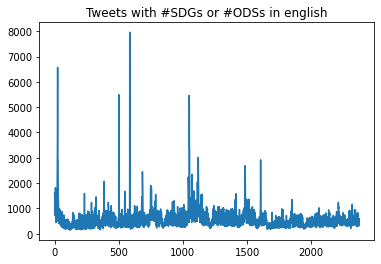

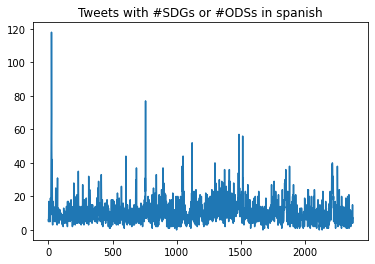

In [ ]:
#Raw plots of the data
plt.plot(counts_dict_en.values())
plt.title("Tweets with #SDGs or #ODSs in english")
plt.show()
plt.plot(counts_dict_es.values())
plt.title("Tweets with #SDGs or #ODSs in spanish")
plt.show()

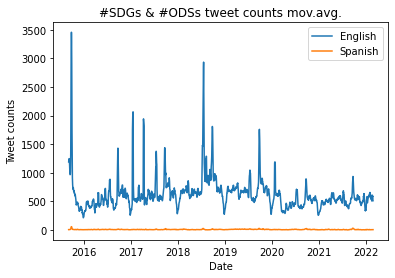

In [ ]:
# Plot together with the moving average
plt.plot(en_df['counts'].rolling(7).sum()/7, label='English')
plt.plot(es_df['counts'].rolling(7).sum()/7, label='Spanish')
plt.legend()
plt.title('#SDGs & #ODSs tweet counts mov.avg.')
plt.xlabel('Date')
plt.ylabel('Tweet counts')
plt.show()

Observations: 
- There is a significant less amounts of tweets about SDGs that are written in spanish.
- Tweet count data has a periodicity (we seem to forget about SDGs around christmas).

In [ ]:
print("Total tweet counts in English: ", int(en_df.sum()))
print("Total tweet counts in Spanish: ", int(es_df.sum()))

Total tweet counts in English:  1491992
Total tweet counts in Spanish:  25748


In [ ]:
# Analyze seasonality
periodic_en = en_df.copy(deep=True)

In [ ]:
periodic_en['date'] = periodic_en.index
periodic_en['day'] = [date.day for date in periodic_en.index]
periodic_en['month'] = [date.month for date in periodic_en.index]
periodic_en['year'] = [date.year for date in periodic_en.index]

display(periodic_en.head())

,counts,day,month,year,date
2015-09-01,1590,1,9,2015,2015-09-01
2015-09-02,1604,2,9,2015,2015-09-02
2015-09-03,1330,3,9,2015,2015-09-03
2015-09-04,1110,4,9,2015,2015-09-04
2015-09-05,752,5,9,2015,2015-09-05


counts
month day            
1     1    319.000000
      2    335.714286
      3    345.571429
      4    397.428571
      5    366.428571

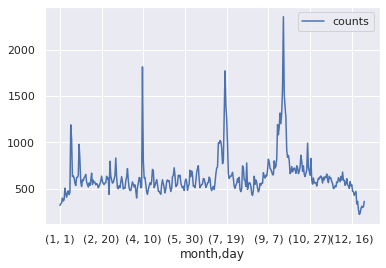

In [ ]:
# group by
T_en = periodic_en.groupby(['month','day']).mean().drop(['year'], axis=1)
display(T_en.head())
T_en.plot();

In [ ]:
# Extract relevant days (english only)
relevant_days = {}
for day, count in counts_dict_en.items():
    if count>2500:
        relevant_days[day] = count
print(relevant_days)

{datetime.date(2015, 9, 23): 2634, datetime.date(2015, 9, 24): 4003, datetime.date(2015, 9, 25): 6572, datetime.date(2015, 9, 26): 3115, datetime.date(2015, 9, 27): 2914, datetime.date(2015, 9, 28): 2892, datetime.date(2017, 1, 14): 5491, datetime.date(2017, 1, 15): 4129, datetime.date(2017, 4, 9): 7960, datetime.date(2018, 7, 16): 4064, datetime.date(2018, 7, 17): 5469, datetime.date(2018, 7, 18): 3419, datetime.date(2018, 7, 19): 3418, datetime.date(2018, 9, 25): 3016, datetime.date(2019, 9, 25): 2685, datetime.date(2020, 1, 24): 2916}


Relevant dates comprise:  
- September 2015: Initial UN SDGs statement (Semptember 2015)
- 14-15 January 2017: UN data forum 
- 9 april 2017: Likely bot from UBS (to be removed for the final dataset)
- August 1018: Fridays for future
- 25 September 2018 and 2019: SDGs anniversary?